<a href="https://colab.research.google.com/github/Arjune7/dataset/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Churn-predictor**

In [1]:
import pandas as pd
import io
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from scipy.stats import randint
from sklearn.svm import SVC

# **Load Data**

In [3]:
from google.colab import files
data_to_load = files.upload()

Saving customer_churn_large_dataset.csv to customer_churn_large_dataset (1).csv


In [6]:
df = pd.read_csv(io.BytesIO(data_to_load['customer_churn_large_dataset (1).csv']))

# **Data Prepartion**

## **Data Cleaning**

In [9]:
# Handling missing values (if any)
df.dropna(inplace=True)  # Dropping rows with missing values

# Encoding categorical variables
label_encoders = {}
categorical_cols = ['Gender', 'Location']
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Scaling numerical features
numerical_cols = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Handling outliers (assuming a simple method to remove outliers)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Splitting the features and target variable
X = df.drop(columns=['CustomerID', 'Name', 'Churn'])
y = df['Churn']

## **Feature Engineering**

In [10]:
# Subscription to Age Ratio:
df['Subscription_to_Age_Ratio'] = df['Subscription_Length_Months'] / df['Age']

# Monthly Bill per GB:
df['Cost_Per_GB'] = df['Monthly_Bill'] / df['Total_Usage_GB']

# List of new feature columns that need to be scaled
new_feature_cols = ['Subscription_to_Age_Ratio', 'Cost_Per_GB']

# Initialize the scaler
scaler = StandardScaler()

# Apply standard scaling to the new features in the entire dataset
df[new_feature_cols] = scaler.fit_transform(df[new_feature_cols])


## **Data Splitting**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Model Training**

## **Logistic Regression**

In [23]:
# Initializing and training the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

### **Model Evaluation**

In [24]:
# Making predictions on the training set
train_predictions = logreg_model.predict(X_train)

# Evaluating the model on the training set
train_accuracy = accuracy_score(y_train, train_predictions)
print(f"Training Accuracy: {train_accuracy:.2f}")

# Generating a classification report for more detailed evaluation
print("\nClassification Report on Training Data:")
print(classification_report(y_train, train_predictions, target_names=['Not Churn', 'Churn']))

# Evaluating the model on the test set
test_predictions = logreg_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Generating a classification report for the test set
print("\nClassification Report on Test Data:")
print(classification_report(y_test, test_predictions, target_names=['Not Churn', 'Churn']))


Training Accuracy: 0.51

Classification Report on Training Data:
              precision    recall  f1-score   support

   Not Churn       0.51      0.62      0.56     40142
       Churn       0.50      0.39      0.44     39858

    accuracy                           0.51     80000
   macro avg       0.51      0.51      0.50     80000
weighted avg       0.51      0.51      0.50     80000

Test Accuracy: 0.50

Classification Report on Test Data:
              precision    recall  f1-score   support

   Not Churn       0.50      0.62      0.56     10079
       Churn       0.49      0.38      0.43      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.50      0.49     20000



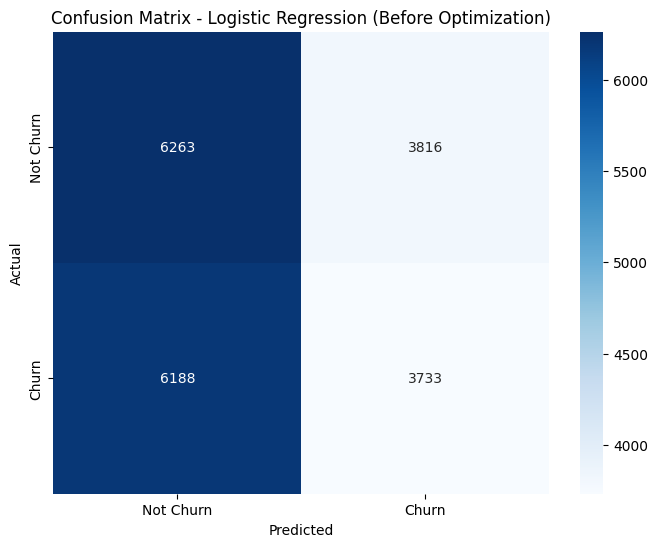

In [34]:
# Confusion Matrix for Logistic Regression before optimization
conf_matrix_lr_before = confusion_matrix(y_test, test_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr_before, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Before Optimization)')
plt.show()


### **Model Optimization**

#### **Cross-validation**

In [26]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(logreg_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:")
print(cv_scores)
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores:
[0.4992  0.50785 0.50365 0.4963  0.50355]
Mean Accuracy: 0.50


#### **Hyperparameter Tuning using Grid Search**

In [27]:

# Define hyperparameters and their possible values
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l2']  # Regularization type
}

# Initialize the model
logreg = LogisticRegression(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Print the best parameters found by grid search
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Best Hyperparameters:
{'C': 0.1, 'penalty': 'l2'}


### **Model Evaluation after optimization**

Test Accuracy: 0.50
Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58     10079
           1       0.50      0.31      0.38      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.50      0.50      0.48     20000



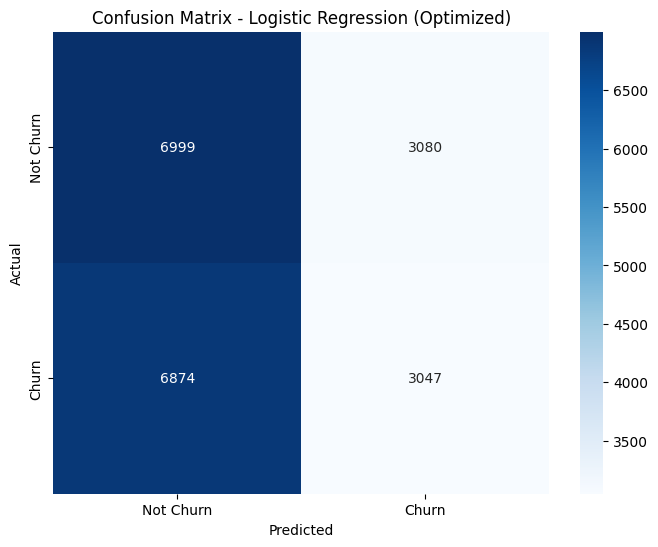

In [37]:
# Assuming X_test contains the features of your test dataset (features for prediction)
# Predict using the optimized model
predictions_lr_optimized = best_model.predict(X_test)

# Assuming y_test contains the true labels for your test dataset
# Evaluate the model's accuracy on the test dataset
test_accuracy_lr_optimized = accuracy_score(y_test, predictions_lr_optimized)
print(f"Test Accuracy: {test_accuracy_lr_optimized:.2f}")

# Generate a classification report for detailed evaluation
print("Classification Report on Test Data:")
print(classification_report(y_test, predictions_lr_optimized))

# Generate and plot the confusion matrix
conf_matrix_lr_optimized = confusion_matrix(y_test, predictions_lr_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr_optimized, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression (Optimized)')
plt.show()


## **Random Forest Classifier**

In [40]:
# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### **Model Evaluation**

In [45]:
# Predictions on the training set
train_predictions = rf_model.predict(X_train)
# Predictions on the test set
test_predictions = rf_model.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Print accuracy scores and formatted classification reports
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

print("\nClassification Report on Training Data:")
print(classification_report(y_train, train_predictions, target_names=['Not Churn', 'Churn']))

print("\nClassification Report on Test Data:")
print(classification_report(y_test, test_predictions, target_names=['Not Churn', 'Churn']))

Training Accuracy: 1.00
Test Accuracy: 0.50

Classification Report on Training Data:
              precision    recall  f1-score   support

   Not Churn       1.00      1.00      1.00     40142
       Churn       1.00      1.00      1.00     39858

    accuracy                           1.00     80000
   macro avg       1.00      1.00      1.00     80000
weighted avg       1.00      1.00      1.00     80000


Classification Report on Test Data:
              precision    recall  f1-score   support

   Not Churn       0.50      0.52      0.51     10079
       Churn       0.50      0.47      0.48      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



### **Model optimization**

#### **Cross validation**

In [18]:
# Perform 5-fold cross-validation on Random Forest
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores for Random Forest:")
print(cv_scores_rf)
print(f"Mean Accuracy: {cv_scores_rf.mean():.2f}")

Cross-Validation Scores for Random Forest:
[0.50475 0.49915 0.49765 0.4975  0.50605]
Mean Accuracy: 0.50


#### **Hyperparameter tuning using Grid Search**

In [21]:
# Define reduced hyperparameters and their possible values for Random Forest
param_grid_rf_reduced = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Random Forest Classifier
rf_model_reduced = RandomForestClassifier(random_state=42)

# Perform grid search with 3-fold cross-validation for Random Forest with reduced search space
grid_search_rf_reduced = GridSearchCV(rf_model_reduced, param_grid_rf_reduced, cv=3, scoring='accuracy')
grid_search_rf_reduced.fit(X, y)

# Print the best parameters found by grid search for Random Forest (reduced search space)
print("Best Hyperparameters for Random Forest (Reduced Search Space):")
print(grid_search_rf_reduced.best_params_)

# Get the best Random Forest model with reduced search space
best_rf_model_reduced = grid_search_rf_reduced.best_estimator_


Best Hyperparameters for Random Forest (Reduced Search Space):
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


### **Model Evaluation after optimization**

In [46]:
# Predictions on the test set using the optimized Random Forest model
test_predictions_rf = best_rf_model_reduced.predict(X_test)

# Calculate accuracy
test_accuracy_rf = accuracy_score(y_test, test_predictions_rf)

# Print test accuracy
print(f"Test Accuracy for Random Forest (Optimized): {test_accuracy_rf:.2f}")

# Generating a classification report for the test set
print("Classification Report for Random Forest (Optimized):")
print(classification_report(y_test, test_predictions_rf))


Test Accuracy for Random Forest (Optimized): 0.53
Classification Report for Random Forest (Optimized):
              precision    recall  f1-score   support

           0       0.53      0.72      0.61     10079
           1       0.55      0.34      0.42      9921

    accuracy                           0.53     20000
   macro avg       0.54      0.53      0.51     20000
weighted avg       0.54      0.53      0.52     20000



##**Support Vector Machine Model**

In [ ]:
# Initialize the SVM model
svm_model = SVC(random_state=42)

# Train the SVM model on the training data
svm_model.fit(X_train, y_train)

### **Model Evaluation**

In [7]:
# Predictions on the test set
svm_predictions = svm_model.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_predictions)
print(f"SVM Test Accuracy: {svm_accuracy:.2f}")

# Generate a classification report for detailed evaluation
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))

NameError: ignored

### **Model Optimization**

#### **Cross-validation**

In [ ]:
# Define the SVM model with the best hyperparameters obtained from the grid search
best_svm_model = SVC(C=1, kernel='linear', random_state=42)

# Perform 5-fold cross-validation
cv_scores_svm = cross_val_score(best_svm_model, X, y, cv=5, scoring='accuracy')

# Print cross-validation scores and mean accuracy
print("Cross-Validation Scores for SVM:")
print(cv_scores_svm)
print(f"Mean Accuracy: {cv_scores_svm.mean():.2f}")

#### **Hyperparameter Tuning Using Grid Search**

In [ ]:
# Define hyperparameters and their possible values for SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
}

# Initialize the SVM Classifier
svm_model = SVC(random_state=42)

# Perform grid search with 5-fold cross-validation for SVM
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X, y)

# Print the best parameters found by grid search for SVM
print("Best Hyperparameters for SVM:")
print(grid_search_svm.best_params_)

# Get the best SVM model
best_svm_model = grid_search_svm.best_estimator_

### **Model Evaluation after optimzation**

In [ ]:
# Predict using the optimized model
predictions_svm = best_svm_model.predict(X_test)

# Assuming y_test contains the true labels for your test dataset
# Evaluate the model's accuracy on the test dataset
test_accuracy_svm = accuracy_score(y_test, predictions_svm)
print(f"Test Accuracy for SVM (Optimized): {test_accuracy_svm:.2f}")

# Generate a classification report for detailed evaluation
print("Classification Report for SVM (Optimized):")
print(classification_report(y_test, predictions_svm, target_names=['Not Churn', 'Churn']))
